# ***MLP***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle  # For saving and loading the model
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
import optuna

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import optuna
import joblib
import time
import numpy as np
pd.options.display.float_format = '{:.3f}'.format

/home/ssilvera/Escritorio/Proyectos/Modelo_pagos/.venvmlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_excel("../Preprocessed data.xlsx")
#df.columns


In [7]:
import os
import joblib
import pandas as pd
import numpy as np
import optuna
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

# Definir columnas numéricas a estandarizar
numeric_cols = ["CAPITAL", "CONTEO_PRODUCTOS", "Cupo", "DiasMejorGestion", "DiasUltimaGestion", "EDAD", 
                'GRUPO', 'Mora_maxima_cliente__Asignacion', 'PgMin', 'SaldoCliente', 'SaldoVencido', 
                'TotalGestiones', 'TotalGestionesCD', 'TotalGestionesCI', 'TotalGestionesCompromiso', 
                'TotalGestionesMasivas', 'TotalGestionesNC', 'dias_mora_Asignacion', 'saldo_total']

# Separar características y variable objetivo
X = df.drop(columns=["Cuenta", "Estado"])  # Excluir identificador y objetivo
y = df["Estado"]

# División en train, val y test (estratificado)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Guardar el scaler (si no está guardado ya)
scaler_filename = "../Models/scaler_MLP_cv_smote.pkl"
if not os.path.exists(scaler_filename):
    scaler = StandardScaler()
    X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    joblib.dump(scaler, scaler_filename)  # Guardar el scaler
else:
    scaler = joblib.load(scaler_filename)  # Cargar el scaler ya guardado
    X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])  # Solo transformar el entrenamiento

# Aplicar SMOTE en el conjunto de entrenamiento después de la estandarización
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Definir nombres de archivos
model_filename = "../Models/mlp_model_cv_smote.keras"
study_filename = "../Study/optuna_study_MLP_cv_smote.pkl"
history_filename = "../Models/history_mlp_model_cv_smote.pkl"

# Obtener el número de características después del preprocesamiento
input_dim = X_train_resampled.shape[1]

# Función objetivo para Optuna
def objective(trial):
    # Espacio de hiperparámetros
    n_layers = trial.suggest_int("n_layers", 1, 2)
    units = trial.suggest_int("units", 32, 128)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)

    # Construcción del modelo
    model = keras.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    
    for _ in range(n_layers):
        model.add(layers.Dense(units, activation="relu"))
        model.add(layers.Dropout(dropout_rate))
    
    model.add(layers.Dense(len(y.unique()), activation="softmax"))  # Salida con clases
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Validación cruzada
    f1_scores = []
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kfold.split(X_train_resampled, y_train_resampled):
        X_train_fold, y_train_fold = X_train_resampled.iloc[train_idx], y_train_resampled.iloc[train_idx]
        X_val_fold, y_val_fold = X_train_resampled.iloc[val_idx], y_train_resampled.iloc[val_idx]
        
        # Aplicar SMOTE en cada fold
        smote_fold = SMOTE(random_state=42)
        X_train_fold, y_train_fold = smote_fold.fit_resample(X_train_fold, y_train_fold)

        # Estandarización por fold
        X_train_fold[numeric_cols] = scaler.transform(X_train_fold[numeric_cols])  
        X_val_fold[numeric_cols] = scaler.transform(X_val_fold[numeric_cols])

        # Entrenamiento con Early Stopping
        early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        
        model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=50,
            batch_size=32,
            verbose=0,
            callbacks=[early_stopping]
        )
        
        # Evaluación en la validación
        y_val_pred = np.argmax(model.predict(X_val_fold), axis=1)
        f1 = f1_score(y_val_fold, y_val_pred, average="weighted")
        f1_scores.append(f1)

    return np.mean(f1_scores)

# Intentar cargar el estudio de Optuna si existe
if os.path.exists(study_filename):
    print(f"Study found. Loading from {study_filename}...")
    study_mlp_balanced = joblib.load(study_filename)
else:
    print("Study not found. Creating a new one...")
    pruner = optuna.pruners.MedianPruner()
    study_mlp_balanced = optuna.create_study(direction="maximize", pruner=pruner)

    # Ejecutar la optimización
    start_time = time.time()
    study_mlp_balanced.optimize(objective, n_trials=50)
    end_time = time.time()

    # Guardar el estudio de Optuna
    joblib.dump(study_mlp_balanced, study_filename)
    print(f"Study saved as {study_filename}")

# Obtener los mejores parámetros de la optimización
best_params = study_mlp_balanced.best_params

# Verificar si el modelo ya existe
if os.path.exists(model_filename):
    print(f"Modelo encontrado. Cargando desde {model_filename}...")
    final_model_balanced = keras.models.load_model(model_filename)
        # Intentar cargar el history
    if os.path.exists(history_filename):
        print(f"History found. Loading from {history_filename}...")
        history = joblib.load(history_filename)
    else:
        print("History not found. No training history to load.")
        history = None
        
    # Estandarización de los conjuntos de datos (train, val, test)
    scaler = joblib.load(scaler_filename)  # Usamos el scaler guardado
    X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
    X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

else:
    print("Modelo no encontrado. Entrenando uno nuevo...")

    # Construcción del modelo final
    final_model_balanced = keras.Sequential()
    final_model_balanced.add(layers.Input(shape=(input_dim,)))

    for _ in range(best_params["n_layers"]):
        final_model_balanced.add(layers.Dense(best_params["units"], activation="relu"))
        final_model_balanced.add(layers.Dropout(best_params["dropout_rate"]))

    final_model_balanced.add(layers.Dense(len(y.unique()), activation="softmax"))

    final_model_balanced.compile(
        optimizer=keras.optimizers.Adam(learning_rate=best_params["learning_rate"]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Aplicar SMOTE en el conjunto de entrenamiento final
    X_train_final, y_train_final = smote.fit_resample(X_train_resampled, y_train_resampled)

    # Estandarización final
    X_train_final[numeric_cols] = scaler.transform(X_train_final[numeric_cols])
    X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
    X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

    # Entrenamiento
    history = final_model_balanced.fit(
        X_train_final, y_train_final,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=32,
        verbose=1
    )

    # Guardar el modelo entrenado y el historial
    final_model_balanced.save(model_filename)
    print(f"Model saved as {model_filename}")

    joblib.dump(history, history_filename)

    print(f"Model saved as {model_filename}")
    print(f"History saved as {history_filename}")

# Evaluación en validación
y_val_pred = np.argmax(final_model_balanced.predict(X_val), axis=1)

print("\nValidation Metrics:")
print(f"F1-Score (Validation): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred))



Study found. Loading from ../Study/optuna_study_MLP_cv_smote.pkl...
Modelo encontrado. Cargando desde ../Models/mlp_model_cv_smote.keras...
History found. Loading from ../Models/history_mlp_model_cv_smote.pkl...
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step

Validation Metrics:
F1-Score (Validation): 0.6795
              precision    recall  f1-score   support

           0       0.75      0.99      0.85      3211
           1       0.75      0.14      0.24       970
           2       0.68      0.35      0.46       586

    accuracy                           0.74      4767
   macro avg       0.73      0.50      0.52      4767
weighted avg       0.74      0.74      0.68      4767



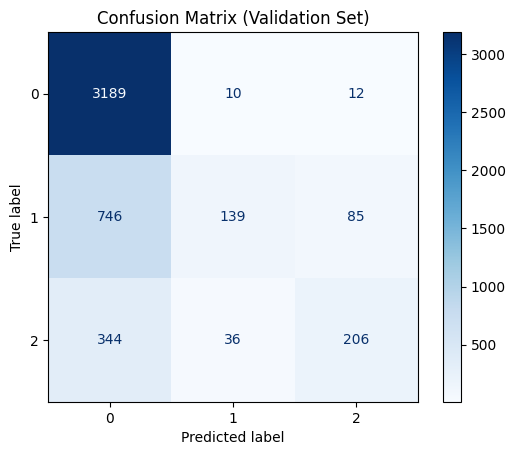

In [8]:
# Matriz de confusión en validación
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(conf_matrix_val, display_labels=np.unique(y_val))
disp_val.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.show()

In [9]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_val, y_val_pred, "MLP Balanced", "./Metrics/Train_Metrics.csv", "./Metrics/Train_Metrics.json")

📂 Reporte de MLP Balanced guardado correctamente.


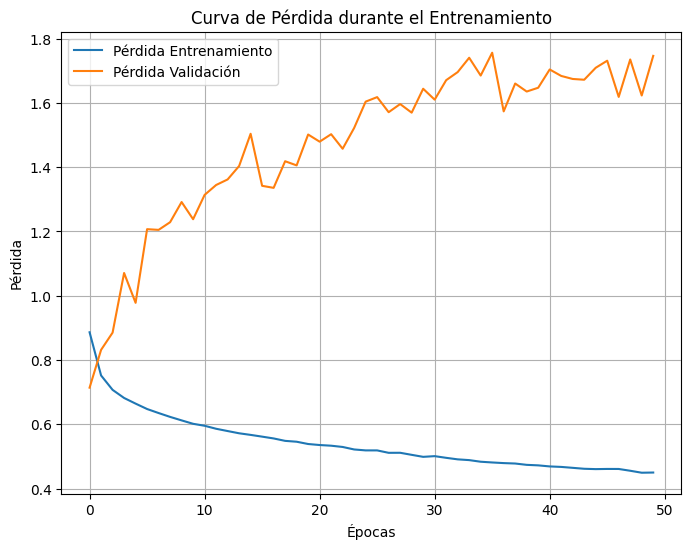

In [10]:
# Graficar la pérdida de entrenamiento y validación
plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Pérdida Entrenamiento")
plt.plot(history.history["val_loss"], label="Pérdida Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Curva de Pérdida durante el Entrenamiento")
plt.legend()
plt.grid()
plt.show()

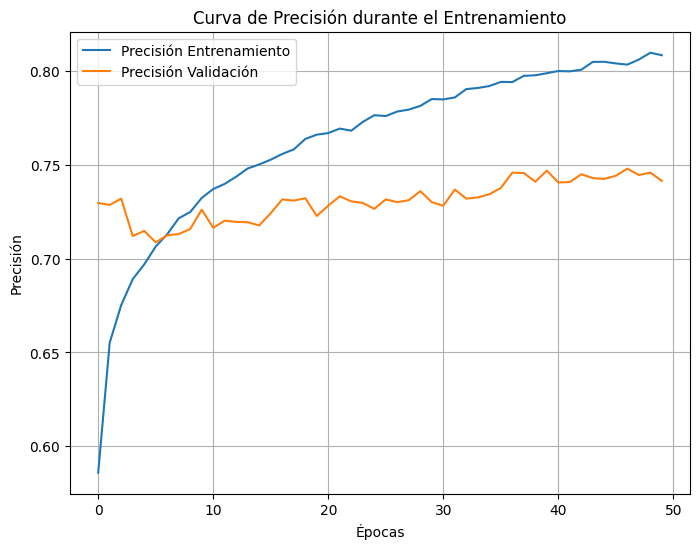

In [11]:
# Graficar la precisión de entrenamiento y validación
plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Precisión Entrenamiento")
plt.plot(history.history["val_accuracy"], label="Precisión Validación")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.title("Curva de Precisión durante el Entrenamiento")
plt.legend()
plt.grid()
plt.show()


In [12]:
# Evaluación en Test
y_test_pred = np.argmax(final_model_balanced.predict(X_test), axis=1)

print("\nValidation Metrics:")
print(f"F1-Score (Test): {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
print(classification_report(y_test, y_test_pred))

149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step

Validation Metrics:
F1-Score (Test): 0.6856
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      3212
           1       0.76      0.16      0.26       969
           2       0.69      0.34      0.45       586

    accuracy                           0.75      4767
   macro avg       0.73      0.50      0.52      4767
weighted avg       0.74      0.75      0.69      4767



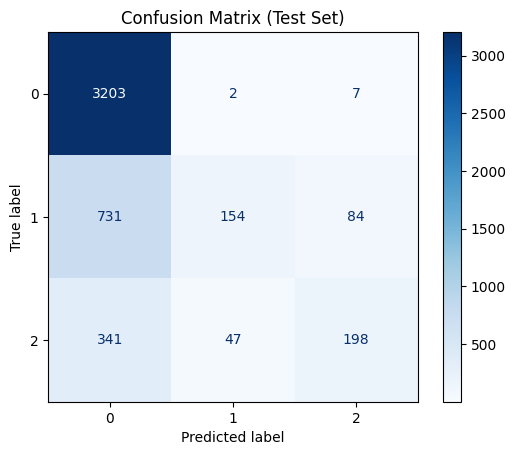

In [13]:
# Matriz de confusión en validación
conf_matrix_val = confusion_matrix(y_test, y_test_pred)
disp_val = ConfusionMatrixDisplay(conf_matrix_val, display_labels=np.unique(y_test))
disp_val.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [14]:
final_model_balanced.summary()

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_143 (Dense)               │ (None, 104)            │         8,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_144 (Dense)               │ (None, 104)            │        10,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 104)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_145 (Dense)               │ (None, 3)              │           315 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,355 (227.95 KB)

 Trainable params: 19,451 (75.98 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,904 (151.97 KB)

In [15]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_test, y_test_pred, "MLP Balanced", "./Metrics/Test_Metrics.csv", "./Metrics/Test_Metrics.json")

📂 Reporte de MLP Balanced guardado correctamente.
